# Домашнее задание 7

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 7 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_7

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим "распределенную" задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum\limits_{i=1}^n f_i(x) = \frac{1}{2n} \sum\limits_{i=1}^n x^T A_i x - b^T_i x,
\end{equation}
где $n = 10$, в качестве матриц $\{A_i\}_{i=1}^n$ - случайные матрицы с $L =1000$, $\mu = 1$, $d = 100$, $\{b_i\}_{i=1}^n$ - так же случайные векторы.

__(а)__ Для такой задачи симулируем распределенное решение (вычисления на 1 компьютере, без распараллеливания). 
Реализуйте обычный распределенный градиентый спуск с операторами сжатия. Сжимайте информацию только от устройств к серверу. Используйте операторы сжатия $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Для каждого случая подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число "переданной информации" от устройств к серверу). Сделайте вывод.

In [1]:
import my_optimization as opt
import numpy as np

In [2]:
#generating the problem setting
args = {}
args['n_workers'] = 10
args['L'] = 1000
args['mu'] = 1
args['d'] = 100
args['seed'] = 40

np.random.seed(args['seed'])
args['A_list'] = [opt.gen_A(args['d'], args['mu'] , args['L']) for i in range(args['n_workers'])]
args['b_list'] = [np.random.rand(args['d']) for i in range(args['n_workers'])]
x_0    = np.random.random_sample(args['d'])

def d_f_quad(x, args):
    res = 0
    for i in range(args['n_workers']):
        res += 1./2 * x.T @ args['A_list'][i] @ x - args['b'][i] @ x
    return res / 2 * args['n_workers']

def d_f_quad_grad(x, args):
    grad_list = []
    for i in range(args['n_workers']):
         grad_list.append(args['A_list'][i] @ x - args['b_list'][i])
    return grad_list

In [3]:
#applying our algorithms
x, y, labels = [], [], []
FLOAT_BYTES = 4
n_iter = 1000

compression_coeffs = [0.01, 0.05, 0.1, 0.2]
#n_iter_list = [int(1000 / (100*n)) for n in compression_coeffs]
rand_k_params_list = [int(args['d'] * v) for v in compression_coeffs]

def rand_k_gd_gamma_th(k, f, grad_f, x_k, x_true, args):
        return 1/(4 * args['L'])

for i in range(len(compression_coeffs)):
    information = [compression_coeffs[i] * FLOAT_BYTES * _ for _ in range(n_iter)]
    x.append(information)

    rand_k_gd_th = opt.GradientOptimizer(d_f_quad, d_f_quad_grad, x_0, criterium = '||grad_f(x_k)||', 
                                        args = args, n_iter = n_iter, gamma_k = rand_k_gd_gamma_th, n_workers = args['n_workers'],
                                        rand_k_activate = True, rand_k_param =  rand_k_params_list[i])

    points_arr, differences_arr, times_arr = rand_k_gd_th.descent()

    y.append(differences_arr)
    #labels.append(r"Rand-, $\gamma = \frac{%i}{4L}$" % 1)
    labels.append(r"Rand-$%i   \gamma = \frac{1}{4L}$" % rand_k_params_list[i])


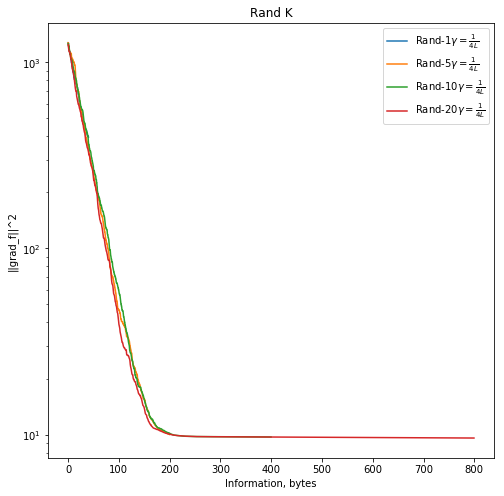

In [4]:
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = "Rand K", logscale = True, criteria_type = "||grad_f||^2")

### Conclusion
With the current theoretical learning rate the best result in terms of the speed of convergence achieves Rand-10, probably because the case is more independent (we have $d = 100, n = 10, k = 10$, so we choose the same coordinates less possibly and the overall coverage is pretty good)

__(б)__ Теперь будем использовать в качестве операторов сжатия $\text{Top}10\%$. Сжимайте информацию только от устройств к серверу. Используйте два метода: обычный распределенный градиентный спуск с операторами сжатия, также распределенный градиентный спуск с техникой компесации ошибки (error feedback - смотри Алгоритм 1 из [статьи](https://arxiv.org/abs/2002.12410)). Для каждого метода подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [5]:
x, y, labels = [], [], []
n_iter = 1000
compression_coeff = 0.1
top_k_param = int(args['d'] * compression_coeff)

def top_k_gd_gamma_th(k, f, grad_f, x_k, x_true, args):
        return args['c']/(args['L'])

c_arr = [1, 1.5, 2]

for args['c'] in c_arr:
    n_communications = [args['n_workers'] * _ for _ in range(n_iter)]
    x.append(n_communications)

    #Basic TopK
    top_k_gd_th = opt.GradientOptimizer(d_f_quad, d_f_quad_grad, x_0, criterium = '||grad_f(x_k)||', 
                                        args = args, n_iter = n_iter, gamma_k = top_k_gd_gamma_th, n_workers = args['n_workers'],
                                        top_k_activate = True, top_k_param =  top_k_param)

    points_arr, differences_arr, times_arr = top_k_gd_th.descent()

    y.append(differences_arr)
    labels.append(r"Top-10, $\gamma = \frac{%i}{L}$" % args['c'])
    
    #Error Feedback
    x.append(n_communications)
    
    ef_top_k_gd_th = opt.GradientOptimizer(d_f_quad, d_f_quad_grad, x_0, criterium = '||grad_f(x_k)||', 
                                        args = args, n_iter = n_iter, gamma_k = top_k_gd_gamma_th, n_workers = args['n_workers'],
                                        ef_activate = True, top_k_param =  top_k_param)

    points_arr, differences_arr, times_arr = ef_top_k_gd_th.descent()

    y.append(differences_arr)
    labels.append(r"EF Top-10, $\gamma = \frac{%i}{L}$" % args['c'])

In [7]:
print(len(x), len(y))

3 6


IndexError: list index out of range

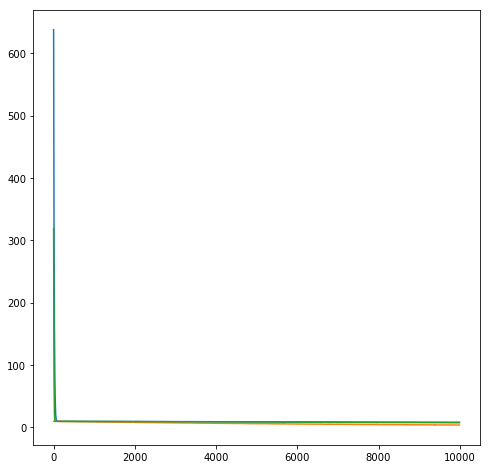

In [6]:
opt.plot_graphs(x, y, x_label = "Communications", lines_labels = labels, title = "Top K", logscale = False, criteria_type = "||grad_f||^2")

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Симмулируем распределенное решение. Для этого разделите обучающую выборку случайно и равномерно на $n=10$ частей. Каждая такая часть сформирует $f_i$.

In [ ]:
#ответ

__(б)__ Реализуйте симмуляцию (как в Задаче 1) обычного распределенного градиентного спуска с операторами сжатия, распределенного градиентного спуска с техникой error feedback, алгоритма DIANA (смотри Алгоритм 11 из [статьи](https://arxiv.org/abs/1905.11261)). Сжатия происходят только при пересылке от сервера к устройствам.

In [ ]:
#ответ

__(в)__ Используйте операторы сжатия $\text{Top}10\%$ и $\text{Rand}10\%$ во всех трех методах (всего получается 6 разных подходов). Для каждого подхода подберите шаг $\gamma$ для наилучшей сходимости, постройте 2 сравнительных графика сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$ или точность предсказаний, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [ ]:
#ответ

__Бонусные пункты__

__(г)__ Реализуйте два метода: [EF21](https://proceedings.neurips.cc/paper/2021/hash/231141b34c82aa95e48810a9d1b33a79-Abstract.html) и [MARINA](https://arxiv.org/abs/2102.07845). Добавьте их к сравнительному анализу из пункта (в) (здесь важно обратить внимание на особенности алгоритма MARINA и отразить это в анализе). Сделайте вывод. 

In [ ]:
#ответ

__(д)__ Добавьте в лучшие 3 (на Ваш взгляд) метода (обычный GD с оператором сжатия, GD с EF, DIANA, EF21, MARINA) возможность сжимать и при передаче от сервера к устройству. Для сжатия используйте только $\text{Top}10\%$ и $\text{Rand}10\%$. Проведите серию экспериментов и ответьте на следующие пункты:

1) Если при сжатии на сервере используются $\text{Top}10\%$ нужно ли использовать технику компесации ошибки на сервере? Опишите, как добавляли еe в метод (лучший вариант - выписать алгоритм частично или целиком). 

2) Перебирая разные комбинации из операторов $\text{Top}10\%$ и $\text{Rand}10\%$ для сжатия на сервера и на устройствах, найдите лучшую конфигурацию операторов сжатия для каждого метода.

3) Какой метод и с каким операторами показал в итоге лучшие результаты? Использовался ли при этом дополнительный error feedback на сервере? 

In [ ]:
#ответ